<a href="https://colab.research.google.com/github/Werikcyano/deeplearning/blob/main/Projeto_1_RNA_Classifica%C3%A7%C3%A3o_bin%C3%A1ria_%5BBase_breast_cancer%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Conteúdo 
---
##1. Redes Neurais Artificiais
> Classificação e regressão

##2. Redes Neurais Convolucionais
>Classificação de imagens

##3. Autoencoders
>Compactação de imagens

>Redução de dimensionalidade  

##4. Redes Adversárias Generativas (GANs)
>Geração de novas imagens

##5. Transferência de Aprendizagem
>Classificação de objetos

##6. Transferência de Estilo
>Mesclar estilos de pinturas e fotos





#Parte 1 - Redes Neurais Artificiais 
---
###1. Projeto 1: Classificação binária [Base breast cancer]
####1.1 Etapas:
>* Etapa 1 - Importação das bibliotecas
>* Etapa 2 - Base de dados
>* Etapa 3 - Transformação de dados para tensores
>* Etapa 4 - Construção de Modelos
>* Etapa 5 - Treinamento de modelos
>* Etapa 6 - Visualização dos pesos
>* Etapa 7 - Avaliação do modelo


#Projeto 1
---

>### Etapa 1 - Importação das bibliotecas

In [71]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score

In [72]:
#no colab o pytorch já vem instalado 
#mas para outros ambientes é bem provável que seja necessária a instalação
import torch
torch.__version__
#caso precise fazer o downgrade 
#!pip install torch==1.4.0

'1.9.0+cu102'

In [73]:
import torch.nn as nn

>### Etapa 2 - Base de Dados

In [74]:
np.random.seed(123)
torch.manual_seed(123)

In [75]:
previsores = pd.read_csv('/content/entradas_breast.csv')
classe = pd.read_csv('/content/saidas_breast.csv')

In [76]:
previsores.shape
##1º - quantidade de linha 
#2º - quantidade de características
#saída -> (quantidade de linha,quantidade de características )

(569, 30)

In [77]:
#Observando os primeiros registros
previsores.head()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave_points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1095.0000,0.9053,8589.0,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3398.0,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,186.0000,275.0000,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4585.0,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,243.0000,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1156.0000,3445.0,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,173.00000
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,198.0000,0.10430,0.1809,0.05883,0.7572,0.7813,5438.0,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,205.0000,0.4000,0.1625,0.2364,0.07678


In [78]:
#observando os primeiros registros das classes
classe.head()

,0
0,0
1,0
2,0
3,0
4,0


In [79]:
#fazendo contagem pra ver quantos elementos temos de cada classe
np.unique(classe)#me retorna um array com as chaves únicas

array([0, 1])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


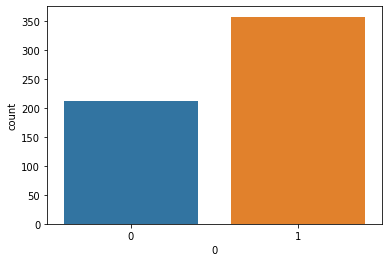

In [80]:
#visualizar um gráfico de contagem
sns.countplot(classe['0']);

In [81]:
#fazer a divisão dessa base de dados
#uma parte para treino e outra para teste
previsores_treinamento, previsores_teste, classe_treinamento, classe_teste = train_test_split(previsores,
                                                                                              classe,
                                                                                              test_size=0.25)
#test_size indica o percentual do dataset que será destinado para teste
#com isso, ficamos com: 25% dos dados para teste e 75% dos dados para treino

In [82]:
previsores_treinamento.shape

(426, 30)

In [83]:
classe_treinamento.shape

(426, 1)

In [84]:
previsores_teste.shape

(143, 30)

In [85]:
classe_teste.shape

(143, 1)

>### Etapa 3 - Transformação dos dados para tensores

In [86]:
type(previsores_treinamento)
#previsores_treinamento está no formato dataframe do pandas
#Precisamos fazer duas transformações:
#1 - Pandas -> Numpy
#2 - Numpy -> pytorch

pandas.core.frame.DataFrame

In [87]:
#convertendo pandas -> numpy
previsores_treinamento = np.array(previsores_treinamento)
type(previsores_treinamento)

numpy.ndarray

In [88]:
#convertendo numpy -> pytorch
previsores_treinamento = torch.tensor(previsores_treinamento, dtype=torch.float)

In [89]:
#para classe farei direto 
#passando todos os argumentos de uma vez só 
classe_treinamento = torch.tensor(np.array(classe_treinamento), dtype= torch.float)

In [90]:
type(previsores_treinamento)

torch.Tensor

In [91]:
type(classe_treinamento)
#aqui é possível notar que os dados já são do tipo 'torch.Tensor' 

torch.Tensor

In [92]:
#vamos fazer a criação de um dataset
#para que possamos passar como parâmetro para o pytorch
#neste caso temos duas variáveis (previsores_treinamento e classe_treinamento),
#precisamos juntar as duas variáveis em uma só, para que possamos passar para o
#pytorch
dataset = torch.utils.data.TensorDataset(previsores_treinamento, classe_treinamento)
#temos uma classe TensorDataset que vai criar um datasete utilizando as duas variáveis
#o próprio pytorch irá identificar que o primeiro parâmetro se trata de previsores
# e o segundo se trata das classes 

In [93]:
#A parti de agora iremos utilizar a variável 'dataset' para passar os dados 
#para o nosso treinamento
type(dataset)

torch.utils.data.dataset.TensorDataset

In [94]:
train_loader = torch.utils.data.DataLoader(dataset, batch_size=10, shuffle=True)
#o pytorch faz o treinamento em mini batchs 
#neste caso o tamanho desse batch é de 10 registros
#ou seja, a cada 10 registros o pytorch recalcula os pesos
#o shuffle serve para indicar que queremos que misture os dados
#o DataLoader é uma classe responsável por fornecer o número certo de dados
# de acordo com o parâmetro batch_size
#além disso essa classe mantém  o histórico dos dados que foram treinados
# de forma a não enviar dados repetidos dentro da mesma época

>### Etapa 4 - Construção do modelo

In [95]:
#Vamos construir uma rede neural da seguinte maneira
# 30 neurônios na camada de entrada --> 16 neurônios --> 16 neurônios --> 1 neurônio
#explicação dos valores:
#--->30 neurônios na camada de entrada é pelo fato de que na nossa base de dados temos
#30 atributos previsores, ou seja, sempre na camada de entrada teremos a quantidade
#de neurônios igual a quantidade de atributos
#--->2 camadas ocultas, contendo  16 neurônios, cada, vem da fórmula=> 
#       (entradas + saídas)/2 = (30+1)/2 = 15,5==> 16 neurônios cada camada oculta.
#---> ultima camada com apenas 1 neurônio vem do fato de a resposta no nosso problema
#ser binária, zero ou um, com isso é necessário apenas um neurônio para nos dar esta resposta
classificador = nn.Sequential(
    nn.Linear(in_features=30, out_features=16),
    nn.ReLU(),
    nn.Linear(16, 16),
    nn.ReLU(),
    nn.Linear(16,1),
    nn.Sigmoid()
)
#explicando  os parâmetros:
#nn.Sequential() indica uma sequencia de camadas definida por nós
#explicando camada por camada:
#nn.Linear(in_features=30, out_features=16) ---> como é o nosso primeiro parâmetro
#indica que é a primeira camada, que nesse caso possui 30 neurônios (in_features=30)
#que se ligam, cada um dos 30 neurônios, aos 16 neurônios da próxima camada (out_features=16)
#esse nn.Linear indica que são ligações densas entre os neurônios de cada camada
#ou seja, cada neurônio da camada atual se liga com todos os neurônios da camada seguinte
#nn.ReLU() --> é a função de ativação escolhida para atuar sobre os neurônios
#nn.Sigmoid() --> Função de ativação escolhida para atuar na minha saída (poderia ser outra)
#Nesse caso a função de ativação sigmoid foi escolhida, pois ela retorna uma probabilidade
#que é exatamente o que queremos, um valor entre zero e um
#mais próximo de 1 ---> tende a ser positivo
#mais próximo de 0 ---> tende a ser negativo

In [96]:
#Vamos visualizar os parâmetros/estrutura da rede neural
classificador.parameters

<bound method Module.parameters of Sequential(
  (0): Linear(in_features=30, out_features=16, bias=True)
  (1): ReLU()
  (2): Linear(in_features=16, out_features=16, bias=True)
  (3): ReLU()
  (4): Linear(in_features=16, out_features=1, bias=True)
  (5): Sigmoid()
)>

In [97]:
#vamos criar a nossa função de erro
criterion = nn.BCELoss()
#automaticamente irá fazer o calculo do erro

In [98]:
#agora vamos criar o nosso otimizador
optimizer = torch.optim.Adam(classificador.parameters(), lr=0.001, weight_decay=0.0001)
#o otimizador utilizado aqui foi o Adam (bastante utilizado)
#parâmetros: 
#   classificador.parameters() ---> a estrutura da rede
#   lr = Learning rate (esse valor é obtido por convensão, olhando o tipo de rede e problema)
#   weight_decay  --->> esse parâmetro indica que após um número 'x' de época o lr vai decaindo
#para conseguir se aproximar mais do gradiente ( ajuda o algoritmo a chegar no mínimo global)

>### Etapa 5 - Treinamento do Modelo

In [99]:
#em outras bibliotecas como keras e tensorflow basta mandar a funcao fit
#com a base de dados que o treinamento é feito
#no nosso caso é diferente
#teremo que fazer a estrutura "for" para fazer esse processo 
for epoch in range(100):
  running_loss = 0.
  for data in train_loader:
    #inputs são as entradas ou previsores
    #labels são as respostas reais ou esperadas
    inputs, labels = data
    #print(inputs)
    #print("-----------")
    #print(labels)
    optimizer.zero_grad()
    outputs = classificador(inputs)#ou ainda classificador.forward(inputs)
    #print(outputs) valores das previsões
    #agora, em comparação entre as previsões (outputs) e as respostas reais
    #que estão em labels, vamos calcular os erros
    loss = criterion(outputs, labels)
    #print(loss)
    #agora vamos fazer o backpropagation
    loss.backward()
    #vamos fazer o ajuste dos pesos
    optimizer.step()#pesos ajustados

    running_loss += loss.item()
  print("Época %3d: perda %.5f" %(epoch+1, running_loss/len(train_loader)))
  #Lembrando que aprendizagem de uma rede neural é a escolha do melhor conjunto de pesos

#temos que são 426 registros e que são passados de 10 em 10   (size batchs)
#por tanto 426/10=42,6-->43 ajustes de pesos em cada época 
#no caso, em cada iteração 'for'
#estamos escolhendo 100 epocas

Época   1: perda 10.78336
Época   2: perda 2.84863
Época   3: perda 1.67480
Época   4: perda 1.11414
Época   5: perda 0.63996
Época   6: perda 0.63753
Época   7: perda 0.58066
Época   8: perda 0.55460
Época   9: perda 0.55617
Época  10: perda 0.53322
Época  11: perda 0.55797
Época  12: perda 0.53816
Época  13: perda 0.52938
Época  14: perda 0.33227
Época  15: perda 0.51360
Época  16: perda 0.35532
Época  17: perda 0.49602
Época  18: perda 0.33208
Época  19: perda 0.29349
Época  20: perda 0.25046
Época  21: perda 0.29527
Época  22: perda 0.49888
Época  23: perda 0.47241
Época  24: perda 0.45883
Época  25: perda 0.27544
Época  26: perda 0.23399
Época  27: perda 0.26373
Época  28: perda 0.24136
Época  29: perda 0.28275
Época  30: perda 0.22633
Época  31: perda 0.19294
Época  32: perda 0.22258
Época  33: perda 0.20290
Época  34: perda 0.20888
Época  35: perda 0.20335
Época  36: perda 0.20316
Época  37: perda 0.18855
Época  38: perda 0.22316
Época  39: perda 0.23315
Época  40: perda 0.19261

>### Etapa 6 - Visualização dos pesos

In [100]:
params = list(classificador.parameters())

In [101]:
params

[Parameter containing:
 tensor([[-3.4083e-01, -4.7026e-01, -4.6565e-01,  7.4826e-02, -1.5653e-02,
           8.7919e-03,  2.7915e-02,  6.5618e-03, -1.7543e-02,  1.3366e-01,
           6.6988e-02,  9.5304e-02, -1.6608e-01,  1.4688e-02,  8.6687e-04,
          -8.8594e-03, -1.6359e-01,  5.0327e-04,  4.7089e-01,  9.6692e-04,
          -2.1427e-01, -5.2192e-01, -3.5202e-01,  9.5634e-02,  7.9063e-01,
           3.0379e-01, -2.6439e-01,  6.1931e-02,  3.2263e-01, -1.2992e-02],
         [ 7.3980e-01,  1.3780e-01,  7.2602e-01,  1.4453e-01, -6.4926e-01,
          -5.4948e-02, -3.1710e-02, -1.8430e-01, -1.5479e-01,  7.0328e-02,
           2.2506e-01, -9.5729e-02, -5.6954e-02,  1.0985e-01, -4.9175e-03,
          -7.2801e-02,  1.9797e-01, -1.6857e-02, -4.2540e-01, -9.6452e-03,
           6.5549e-01, -3.6487e-01,  4.9125e-01,  6.3752e-02, -1.2041e-01,
          -2.2323e-01, -6.2139e-01,  1.5040e-02, -3.4235e-01, -3.0804e-01],
         [-5.4652e-02, -1.2591e-01, -3.1521e-01, -1.1080e-01, -1.7244e-04,


In [102]:
#pesos da primeira camada de ligação (braços)
pesos0 = params[0]
pesos0.shape

torch.Size([16, 30])

In [103]:
print(pesos0)
#essa saída fica algo como:
#uma lista com 16 itens e cada item desses 16, composto por 30 valores
#que são os valores de entre cada neurônio dos 16 da primeira camada oculta
#ligando aos 30 da primeira camada da rede


Parameter containing:
tensor([[-3.4083e-01, -4.7026e-01, -4.6565e-01,  7.4826e-02, -1.5653e-02,
          8.7919e-03,  2.7915e-02,  6.5618e-03, -1.7543e-02,  1.3366e-01,
          6.6988e-02,  9.5304e-02, -1.6608e-01,  1.4688e-02,  8.6687e-04,
         -8.8594e-03, -1.6359e-01,  5.0327e-04,  4.7089e-01,  9.6692e-04,
         -2.1427e-01, -5.2192e-01, -3.5202e-01,  9.5634e-02,  7.9063e-01,
          3.0379e-01, -2.6439e-01,  6.1931e-02,  3.2263e-01, -1.2992e-02],
        [ 7.3980e-01,  1.3780e-01,  7.2602e-01,  1.4453e-01, -6.4926e-01,
         -5.4948e-02, -3.1710e-02, -1.8430e-01, -1.5479e-01,  7.0328e-02,
          2.2506e-01, -9.5729e-02, -5.6954e-02,  1.0985e-01, -4.9175e-03,
         -7.2801e-02,  1.9797e-01, -1.6857e-02, -4.2540e-01, -9.6452e-03,
          6.5549e-01, -3.6487e-01,  4.9125e-01,  6.3752e-02, -1.2041e-01,
         -2.2323e-01, -6.2139e-01,  1.5040e-02, -3.4235e-01, -3.0804e-01],
        [-5.4652e-02, -1.2591e-01, -3.1521e-01, -1.1080e-01, -1.7244e-04,
          1.31

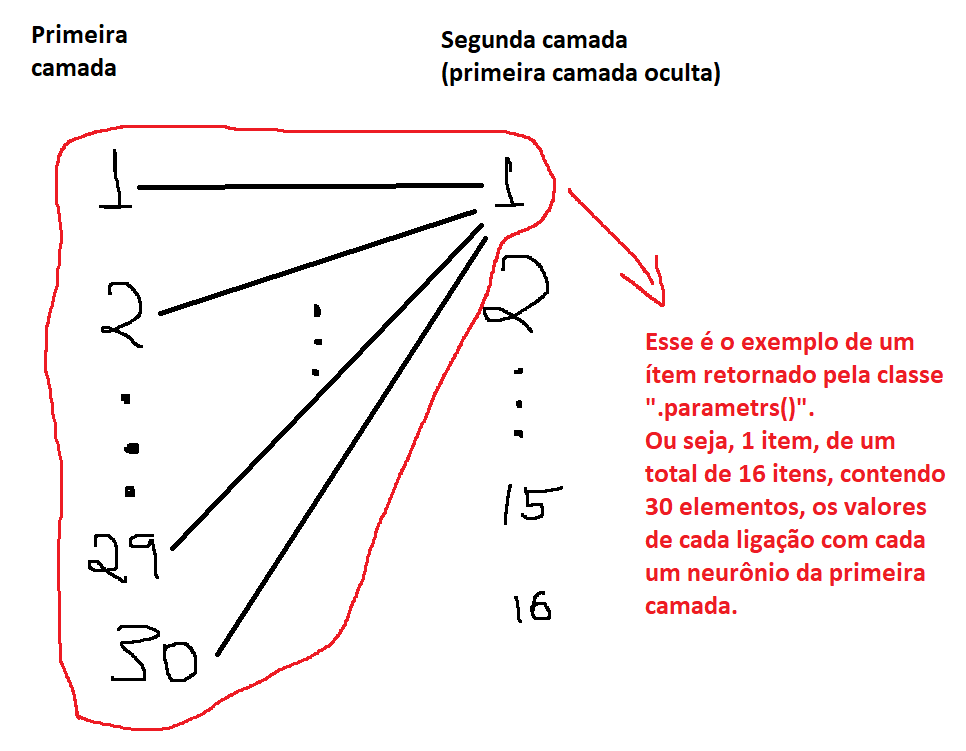

In [104]:
#bias da primeira camada de ligação (braços)
bias0 = params[1]
bias0.shape

torch.Size([16])

In [105]:
#pesos da segunda camada de ligação (braços)
pesos1 = params[2]
pesos1.shape

torch.Size([16, 16])

In [106]:
#bias da segunda camada de ligação (braços)
bias1 = params[3]
bias1.shape

torch.Size([16])

In [107]:
#pesos da terceira camada de ligação (braços)
pesos2 = params[4]
pesos2.shape

torch.Size([1, 16])

In [108]:
#bias da terceira camada de ligação (braços)
bias2 = params[5]
bias2.shape

torch.Size([1])

Ressaltando que uma vez que a rede possui esses pesos, ela irá utilizá-los para fazer uma classificação

>### Etapa 7 - Avaliação do modelo

In [109]:
#vamos colocar o classificador em modo de avaliação
#ou seja, deixar de atualizar os pesos
#pra isso chamamos o .eval
classificador.eval()

Sequential(
  (0): Linear(in_features=30, out_features=16, bias=True)
  (1): ReLU()
  (2): Linear(in_features=16, out_features=16, bias=True)
  (3): ReLU()
  (4): Linear(in_features=16, out_features=1, bias=True)
  (5): Sigmoid()
)

In [110]:
type(previsores_teste)

pandas.core.frame.DataFrame

In [111]:
#pandas--> numpy---> pythorc
previsores_teste = torch.tensor(np.array(previsores_teste), dtype=torch.float)

In [112]:
type(previsores_teste)

torch.Tensor

In [113]:
previsoes = classificador.forward(previsores_teste)

In [114]:
previsoes

tensor([[1.0000e+00],
        [1.0000e+00],
        [5.7935e-03],
        [1.0000e+00],
        [2.1276e-07],
        [9.9763e-01],
        [9.9902e-01],
        [1.0000e+00],
        [9.7305e-01],
        [9.9700e-01],
        [1.0000e+00],
        [1.0000e+00],
        [1.1157e-01],
        [1.0000e+00],
        [1.0000e+00],
        [8.0761e-01],
        [1.0000e+00],
        [1.0000e+00],
        [9.8015e-01],
        [1.0000e+00],
        [3.0639e-17],
        [3.3150e-09],
        [8.9117e-01],
        [1.0000e+00],
        [9.9827e-01],
        [2.5109e-02],
        [9.9835e-01],
        [1.0000e+00],
        [1.0286e-16],
        [1.0000e+00],
        [9.5482e-01],
        [9.9999e-01],
        [9.8775e-01],
        [1.0000e+00],
        [5.9526e-02],
        [1.0000e+00],
        [9.8939e-01],
        [1.0000e+00],
        [1.0000e+00],
        [3.4022e-04],
        [1.3151e-03],
        [9.9563e-01],
        [6.5563e-22],
        [1.9248e-01],
        [7.5770e-11],
        [9

In [115]:
#definindo um limiar das probabilidades
previsoes = np.array(previsoes>0.5)

In [116]:
previsoes

array([[ True],
       [ True],
       [False],
       [ True],
       [False],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [False],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [False],
       [False],
       [ True],
       [ True],
       [ True],
       [False],
       [ True],
       [ True],
       [False],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [False],
       [ True],
       [ True],
       [ True],
       [ True],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [ True],
       [False],
       [ True],
       [False],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [False],
       [False],
       [ True],
       [False],
       [ True],
       [

In [117]:
classe_teste

,0
333,1
273,1
201,0
178,1
85,0
...,...
230,0
282,0
535,0
436,1


In [118]:
taxa_acerto = accuracy_score(classe_teste, previsoes)
taxa_acerto

0.9090909090909091

In [119]:
matriz = confusion_matrix(classe_teste, previsoes)
matriz

array([[45,  9],
       [ 4, 85]])

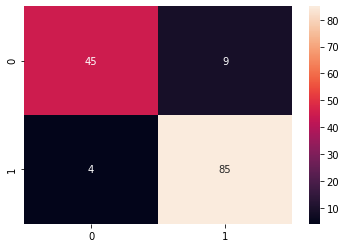

In [120]:
sns.heatmap(matriz, annot=True);